# Assignment 3

In [1]:
# setup

import numpy as np
import matplotlib.pyplot as plt
import gym
import time
# import model.w_sarsa as model

discount=1.00
alpha=0.01

                           
#-----------------------------------------------------------

# For Frozen Lake we use a 1-hot representation
#  of the discrete space which is equivalent to the tabular case

def prepFrozen(map_name=None):
    np.random.seed(5467)
    env = gym.make('FrozenLake-v1',desc=None,map_name=map_name)
    nA=env.nA
    nS=env.nS
    env.seed(48304)
    return(env,nS,nA)
    
def frozenPhi8(s):
    a=np.zeros(64)
    a[s]=1.0
    return(a)

def prepFrozen8():
    dname="Frozen8"
    env,nS,nA=prepFrozen()
    mymaxsteps=1000
    env._max_episode_steps = mymaxsteps
    dim=64 
    return(env,dim,nA,frozenPhi8,dname)

def frozenPhi4(s):
    a=np.zeros(16)
    a[s]=1.0
    return(a)

def prepFrozen4():
    dname="Frozen4"
    env,nS,nA=prepFrozen(map_name='4x4')
    mymaxsteps=250
    env._max_episode_steps = mymaxsteps
    dim=16
    return(env,dim,nA,frozenPhi4,dname)

#-----------------------------------------------------------

# For cart pole we use the original features

# Actions:
#        Type: Discrete(2)
#        Num	Action
#        0	Push cart to the left
#        1	Push cart to the right

# Observation: 
#        Type: Box(4)
#        Num	Observation                 Min         Max
#        0	Cart Position             -4.8            4.8
#        1	Cart Velocity             -Inf            Inf
#        2	Pole Angle                 -24 deg        24 deg
#        3	Pole Velocity At Tip      -Inf            Inf

def identity(x):
    return x

        
def prepCartPole(map_name=None):
    np.random.seed(5467)
    env = gym.make('CartPole-v0')
    dname="CartPole"
    env.seed(48304)
    nA=2
    dim=np.shape(env.observation_space)[0] 
    mymaxsteps=500
    env._max_episode_steps = mymaxsteps
    return(env,dim,nA,identity,dname)

#-----------------------------------------------------------

# For the Lunar Lander we add some features
#  to make the linear representation more expressive

# LunarLander-v2 4 actions
# Nop, fire left engine, main engine, right engine
# self.action_space = spaces.Discrete(4)

# state
# (pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2),
# (pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_H/SCALE/2),
# vel.x*(VIEWPORT_W/SCALE/2)/FPS,
# vel.y*(VIEWPORT_H/SCALE/2)/FPS,
# self.lander.angle,
# 20.0*self.lander.angularVelocity/FPS,
# 1.0 if self.legs[0].ground_contact else 0.0,
# 1.0 if self.legs[1].ground_contact else 0.0

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def LunarPhi(s):
    x,y,vx,vy,a,va,ll,lr=s
    return(sigmoid(np.array([x,y,vx,vy,a,va,x*vx,y*vy,(100-y)*(100-x),a*va,ll,lr])))
    
def prepLunarLander(mymaxsteps=100):
    np.random.seed(5467)
    env = gym.make('LunarLander-v2')
    dname="LunarLander"
    env.seed(48304)
    dim=np.shape(env.observation_space)[0]+4
    nA=env.action_space.n
    print(dname,dim,nA)
    mymaxsteps=100
    env._max_episode_steps = mymaxsteps
    return(env,dim,nA,LunarPhi,dname)

#-----------------------------------------------------------

# stub for your code
# replace demo with sarsa

def getdecayfactor(numepisodes,lowepsilon=0.01,highepsilon=0.5):
    decayfactor=np.exp((np.log(lowepsilon/highepsilon)) / (0.8* numepisodes))
    return(decayfactor)

def demo(env,nS,nA,phi,dname,render=False):
    print("Demo environment ",dname)
    s = phi(env.reset())
    for t in range(env._max_episode_steps):
        if render:
            env.render()
        time.sleep(0.1)
        action = env.action_space.sample()
        s, reward, done, info = env.step(action)
        s2=phi(s)
        print("Phi(state) is ",s2)
        if done:
            break
    if render:
        env.close()

def demoenv(prepFunction,render=False):
    env,nS,nA,phi,dname=prepFunction()
    demo(env,nS,nA,phi,dname,render=render)


# run demo

print("decay factor",getdecayfactor(100000))

#demoenv(prepFrozen8,render=False)
# demoenv(prepFrozen4,render=False)
# time.sleep(2)

# demoenv(prepCartPole,render=True)
# time.sleep(2)

# demoenv(prepLunarLander,render=True)


#-----------------------------------------------------------
# env,nS,nA,phi,dname=prepFrozen4()
# # print("1",phi(0))
# ret = model.sarsa(env,nS,nA,phi,episodes=100000,alpha=0.01,gamma=1)

# env,nS,nA,phi,dname=prepCartPole()
# ret = model.sarsa(env,nS,nA,phi,episodes=100000,alpha=0.01,gamma=1)

# env,nS,nA,phi,dname=prepLunarLander()
# ret = model.sarsa(env,nS,nA,phi,episodes=100000,alpha=0.01,gamma=1)

decay factor 0.9999511009080317


In [37]:
# Sarsa

import numpy as np

def initialize(env,nS,nA,state):
    w = np.random.rand(nS,nA)
    return w

def getdecayfactor(numepisodes,lowepsilon=0.01,highepsilon=0.5):
    decayfactor=np.exp((np.log(lowepsilon/highepsilon)) / (0.8* numepisodes))
    return(decayfactor)

def evaluate(env, w, episode, phi, evaluation, evaluation_episode):
    e = 0
    t_reward = 0
    state = env.reset()
#     Q(s) is same as phi(s).T@w
    action = np.argmax(phi(state).T@w)
    
    while e < 100:
        e+=1
        while True:
            next_state, reward, done, info = env.step(action)
            state = next_state
            t_reward += reward
            action = np.argmax(phi(state).T@w)
            if done:
                state = env.reset()
                break
    avg_reward = t_reward/e
    
    evaluation.append(avg_reward)
    evaluation_episode.append(episode)
    
def epsilon_greedy(phi, w, s2, epsilon):
    if epsilon < 0.01:
        epsilon = 0.01
    if np.random.uniform(0,1) < epsilon:
        a2 = np.random.randint(nA)
    else:
        a2 = np.argmax(phi(s2).T@w)
    return a2

def sarsa(env,nS,nA,phi,episodes,alpha,gamma):
    
    epsilon = 0.5
    c = getdecayfactor(episodes)
    
    w = initialize(env,nS,nA,phi)
    evaluation = []
    evaluation_episode = []
    
    for episode in range(episodes):
        # print("episode epsilon: ", epsilon)
        if episode%50 == 0:
            evaluate(env, w, episode, phi, evaluation, evaluation_episode)
            
        s = env.reset()
        a = np.argmax(phi(s).T@w)
        
        while True:
            s2,r,done,info = env.step(a)
            a2 = epsilon_greedy(phi, w, s2, epsilon)
            
            if done:
                epsilon = epsilon*c
                w[:,a] += np.dot(alpha*(r - phi(s).T.dot(w[:,a])), phi(s))
                break
            w[:,a] += np.dot(alpha*(r + (phi(s2).T.dot(w[:,a2]) - phi(s).T.dot(w[:,a]))), phi(s)) 
            s = s2
            a = a2         
#         print("w: ", w)

    return evaluation, evaluation_episode

In [150]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

def plot(x_vals, l1, l2, l3, l4, title):
    mean = np.mean((l1, l2, l3, l4), axis=0)
    std = np.std((l1,l2,l3,l4), axis=0)
#     plt.plot(mean)
    plt.errorbar(x_vals, mean, std, linestyle="None", marker="*", capsize=5)
    plt.xlabel('episodes', fontsize=20)
    plt.ylabel('average rewards', fontsize=20)
    plt.title(title, fontsize=28)
    plt.rcParams["figure.figsize"] = (50,20)
    plt.xticks(fontsize=20, rotation=90)
    plt.show()
    
def plot2(x_vals, l1, l2, title):
    mean = np.mean((l1, l2), axis=0)
    std = np.std((l1, l2), axis=0)
#     plt.plot(mean)
    plt.errorbar(x_vals, mean, std, linestyle="None", marker="*", capsize=5)
    plt.xlabel('episodes', fontsize=20)
    plt.ylabel('avergae rewards', fontsize=20)
    plt.title(title, fontsize=28)
    plt.rcParams["figure.figsize"] = (50,20)
    plt.xticks(fontsize=20, rotation=90)
    plt.show()
    
def plot_mean(x_vals, l1, l2, title):
    plt.plot(l1)
    plt.plot(l2)
    plt.title(title, fontsize=20)
    plt.rcParams["figure.figsize"] = (50,20)
    plt.show()

# Frozen Lake 8:

In [39]:
env,nS,nA,phi,dname=prepFrozen8()
evals_fl8 = []
eval_episodes = []
for i in range(2):
    ret = sarsa(env,nS,nA,phi,episodes=80000,alpha=0.01,gamma=1)
    evals_fl8.append(ret[0])
    eval_episodes.append(ret[1])

In [43]:
evals_fl8[0][-10:]

[0.56, 0.61, 0.56, 0.56, 0.61, 0.59, 0.64, 0.64, 0.64, 0.6]

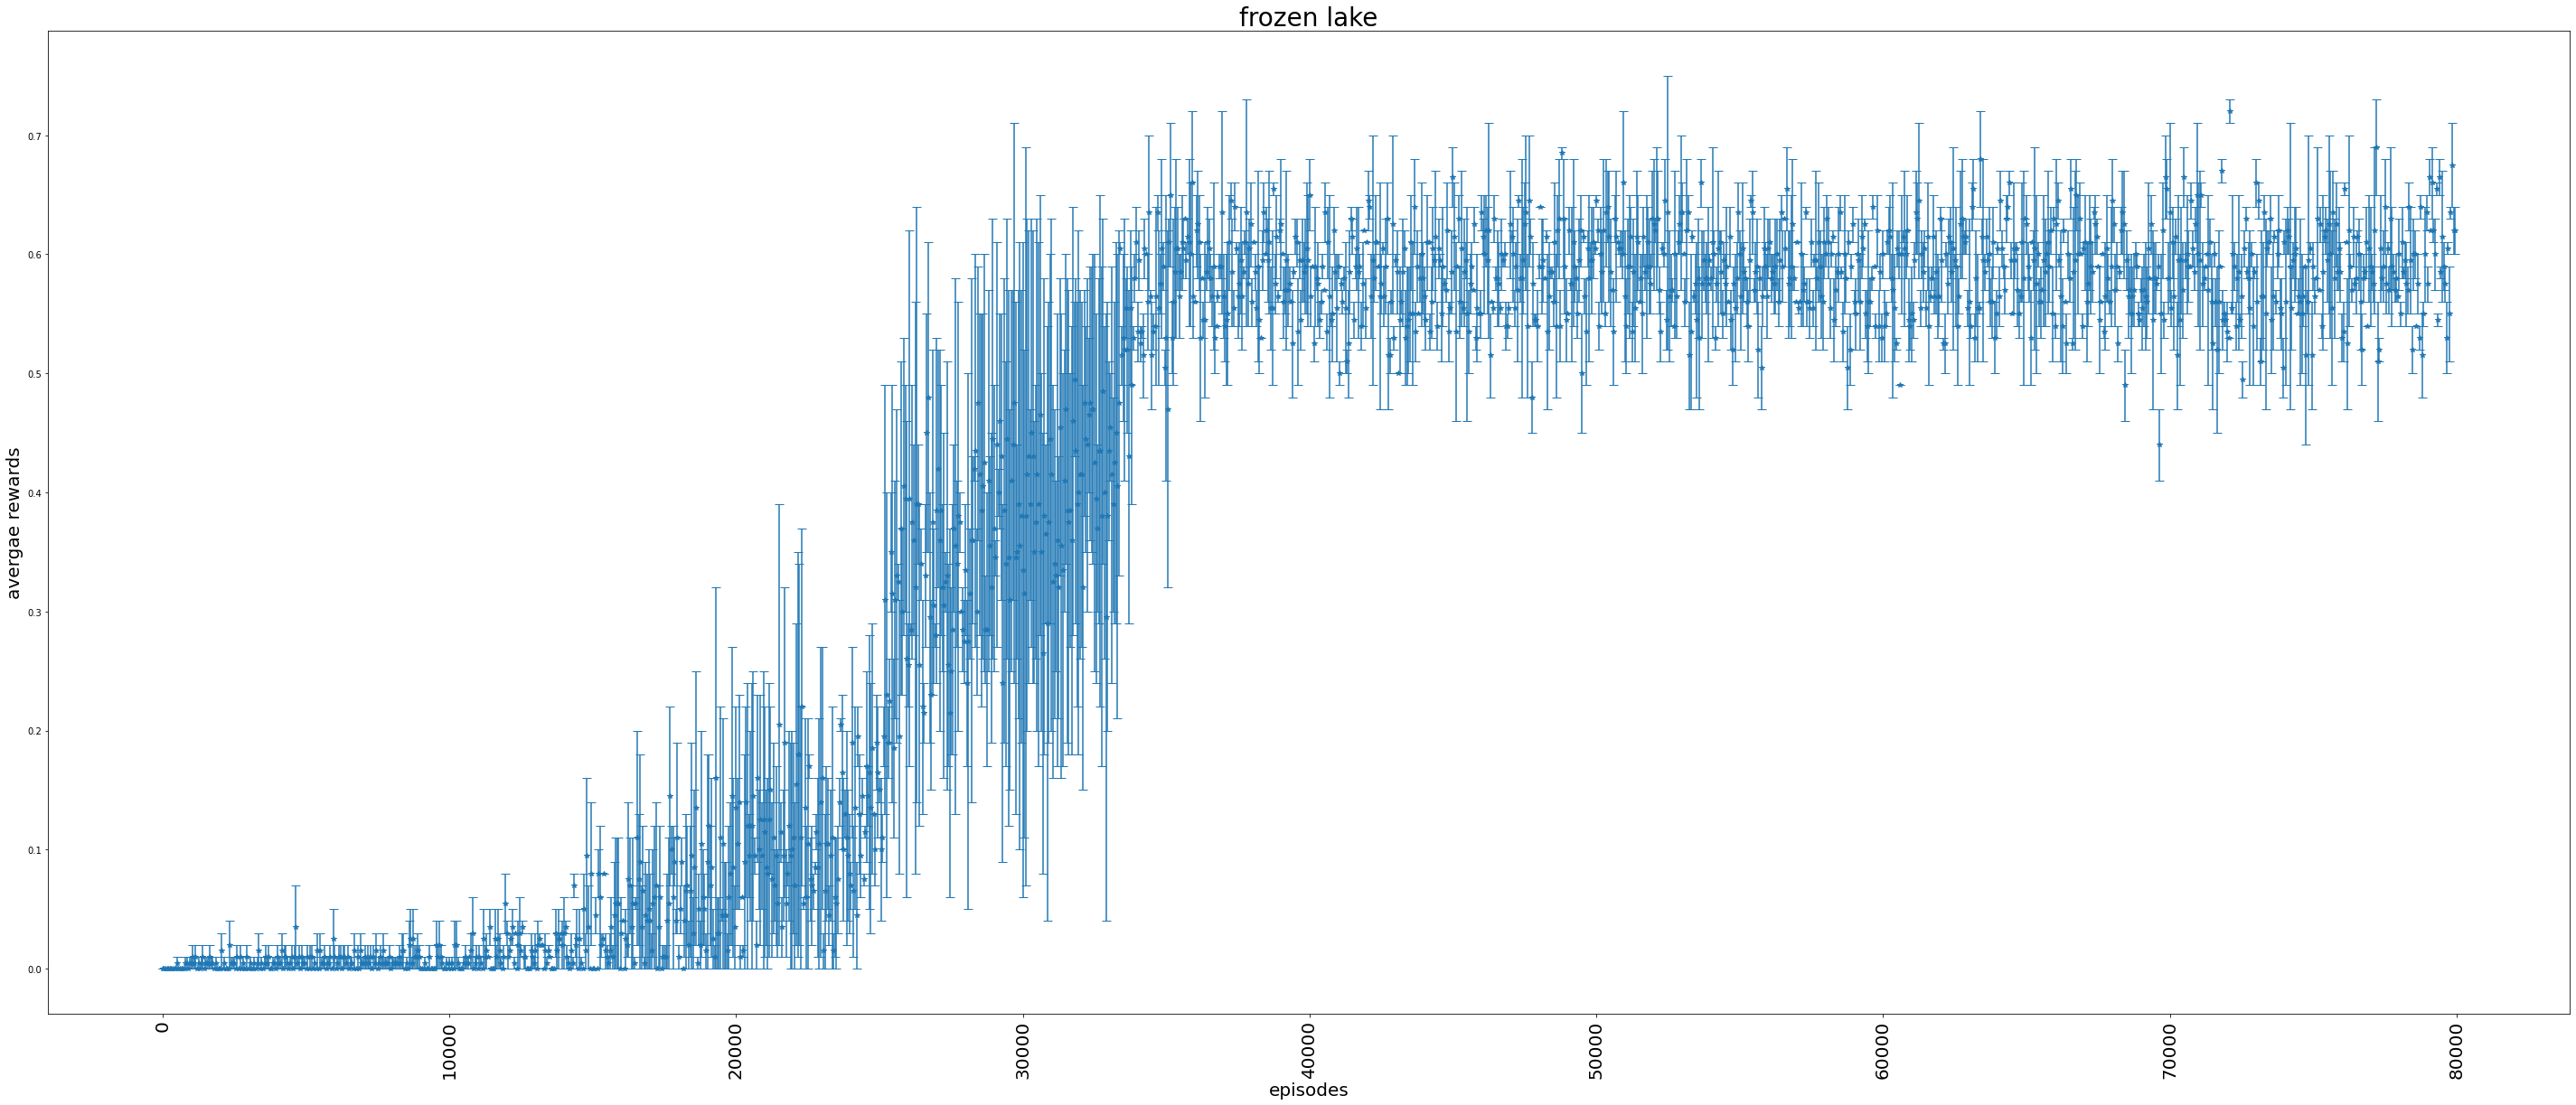

In [151]:
plot2(list(range(0, 80000, 50)), np.array(evals_fl8[0]), np.array(evals_fl8[1]), "frozen lake")

#  FL8

## Implementation:
1. Run for 90000 episides.
2. Best results optained with decaying epsilon.

## Results:
1. Last 10 average rewards are - 0.56, 0.61, 0.56, 0.56, 0.61, 0.59, 0.64, 0.64, 0.64, 0.6

2. The mean reward starts converging to 0.6 at around 40000 steps.

3. The standard deviation converges(decreases) with the episodes.

4. The mean reward has also touch 0.7 in some cases

# Cartpole:

In [70]:
env,nS,nA,phi,dname=prepCartPole()
evals = []
for i in range(4):
    print("running iteration: ",i)
    ret = sarsa(env,nS,nA,phi,episodes=90000,alpha=0.01,gamma=1)
    evals.append(ret)

running iteration:  0
running iteration:  1
running iteration:  2
running iteration:  3


In [96]:
rewards_cp = []
episodes_cp = []
for e in evals:
    rewards_cp.append(e[0])
    episodes_cp.append(e[1])


In [100]:
rewards_cp[1][-10:]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]

In [107]:
rewards_cp[0][-10:]

[28.18, 28.1, 28.82, 28.8, 27.71, 28.69, 27.8, 28.72, 27.91, 29.37]

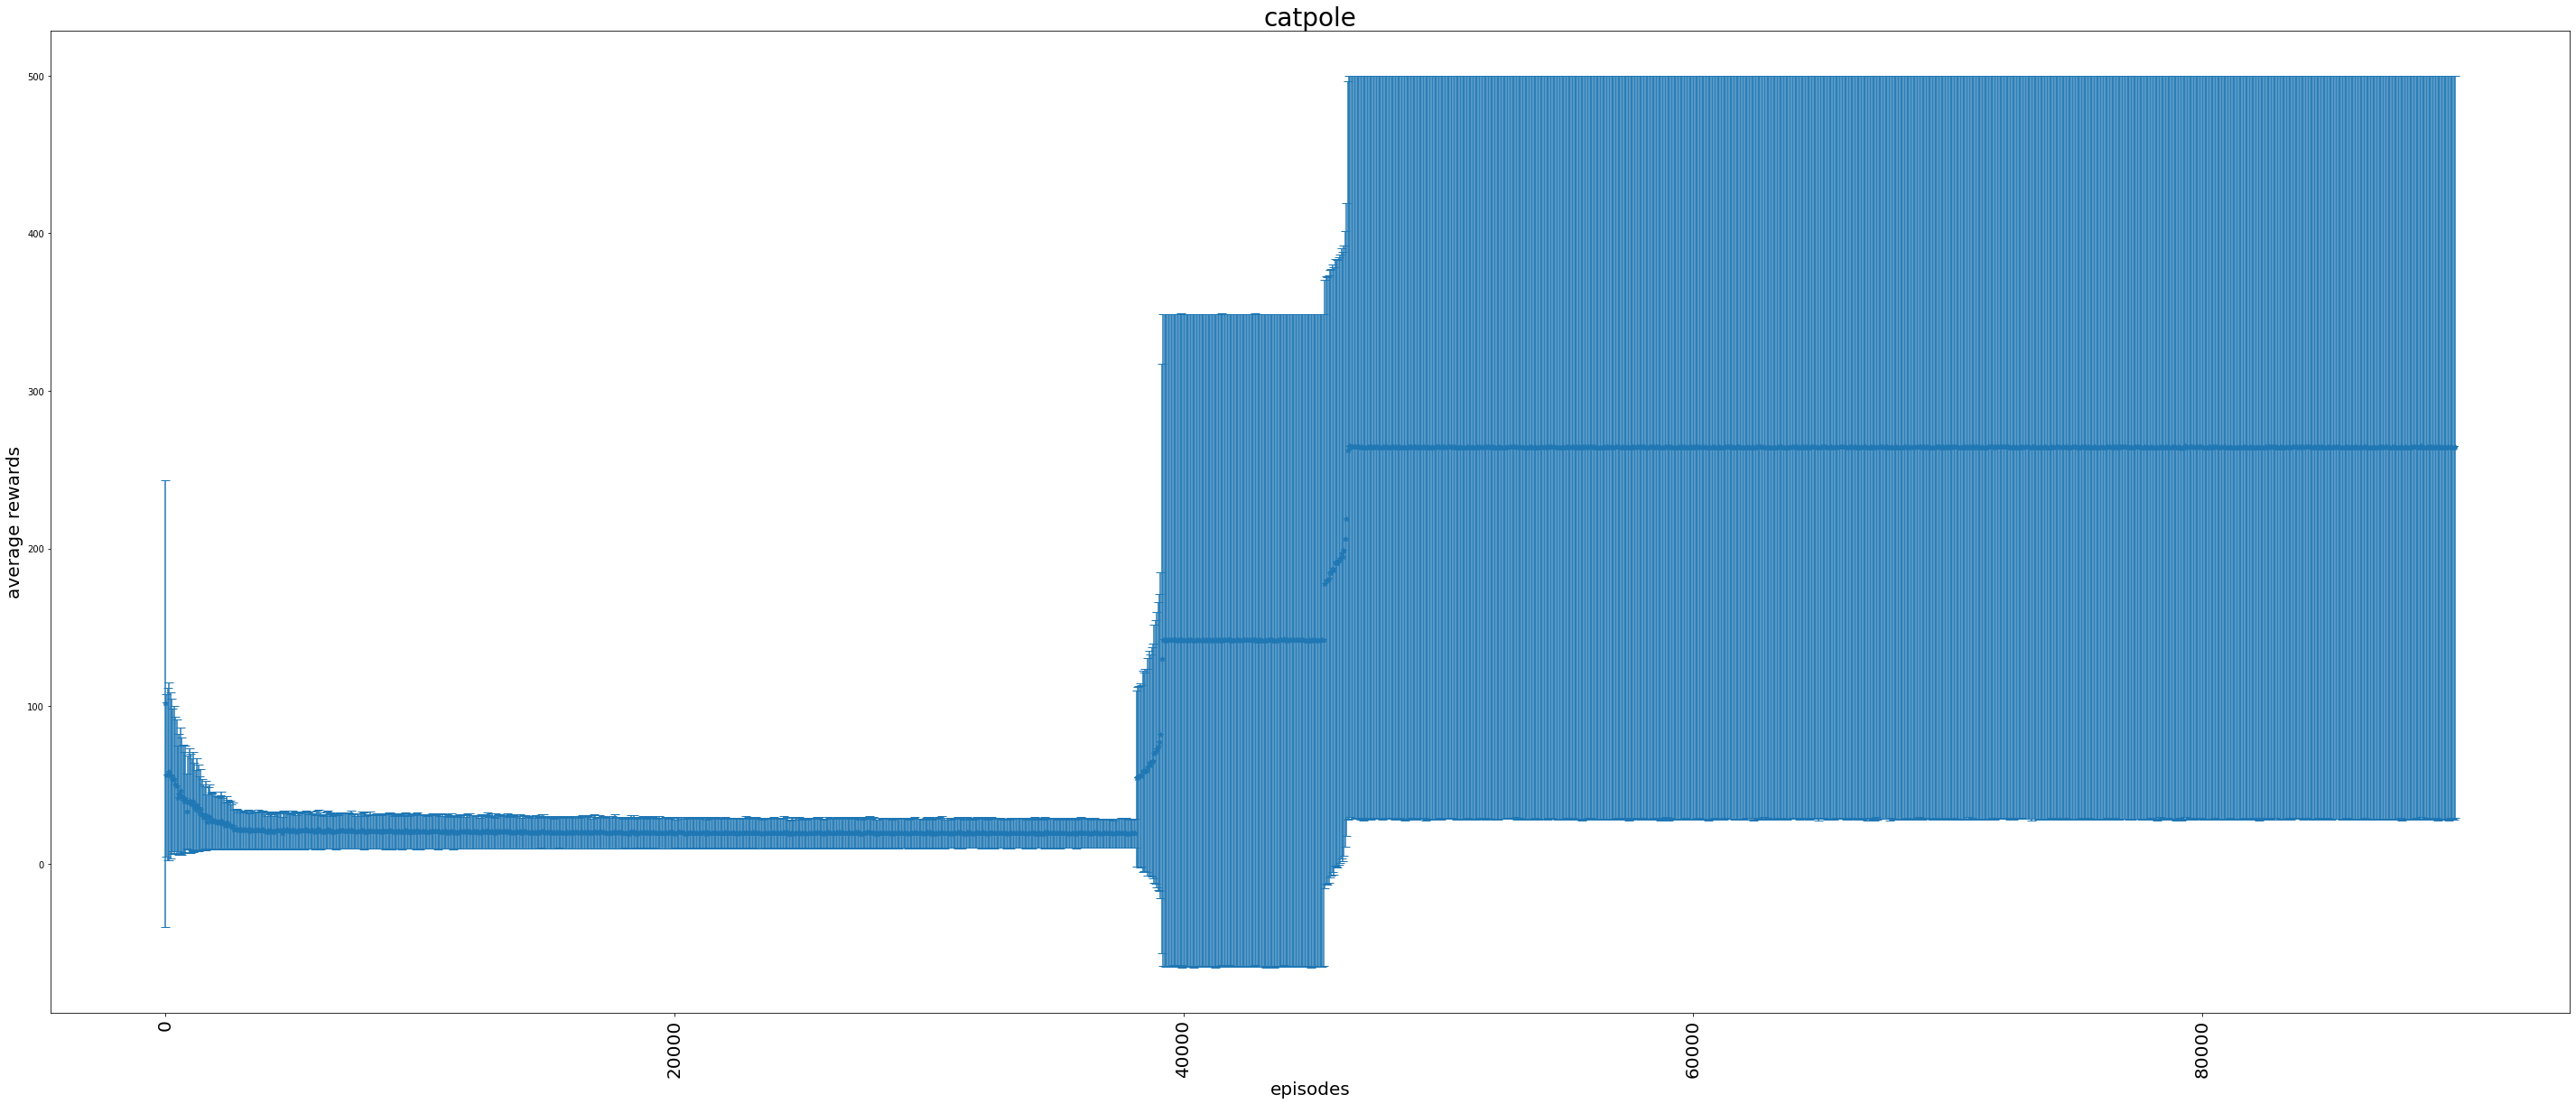

In [152]:
plot(episodes_cp[0], np.array(rewards_cp[0]), np.array(rewards_cp[1]), np.array(rewards_cp[2]), np.array(rewards_cp[3]), "catpole")

#  Cartpole

## Implementation:
1. Run for 90000 episides.
2. Run for 4 iterations
3. Best results optained with decaying epsilon.

## Results:

1. (Fig. Below - Orange) Last 10 average rewards for one of the runs - [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]

2. (Fig. Below - Blue) Last 10 average rewards for another run- [28.18, 28.1, 28.82, 28.8, 27.71, 28.69, 27.8, 28.72, 27.91, 29.37]

3. There are multiple optimas as clear from the above rewards

4. The mean reward starts converging to 300 at around 45000 steps.

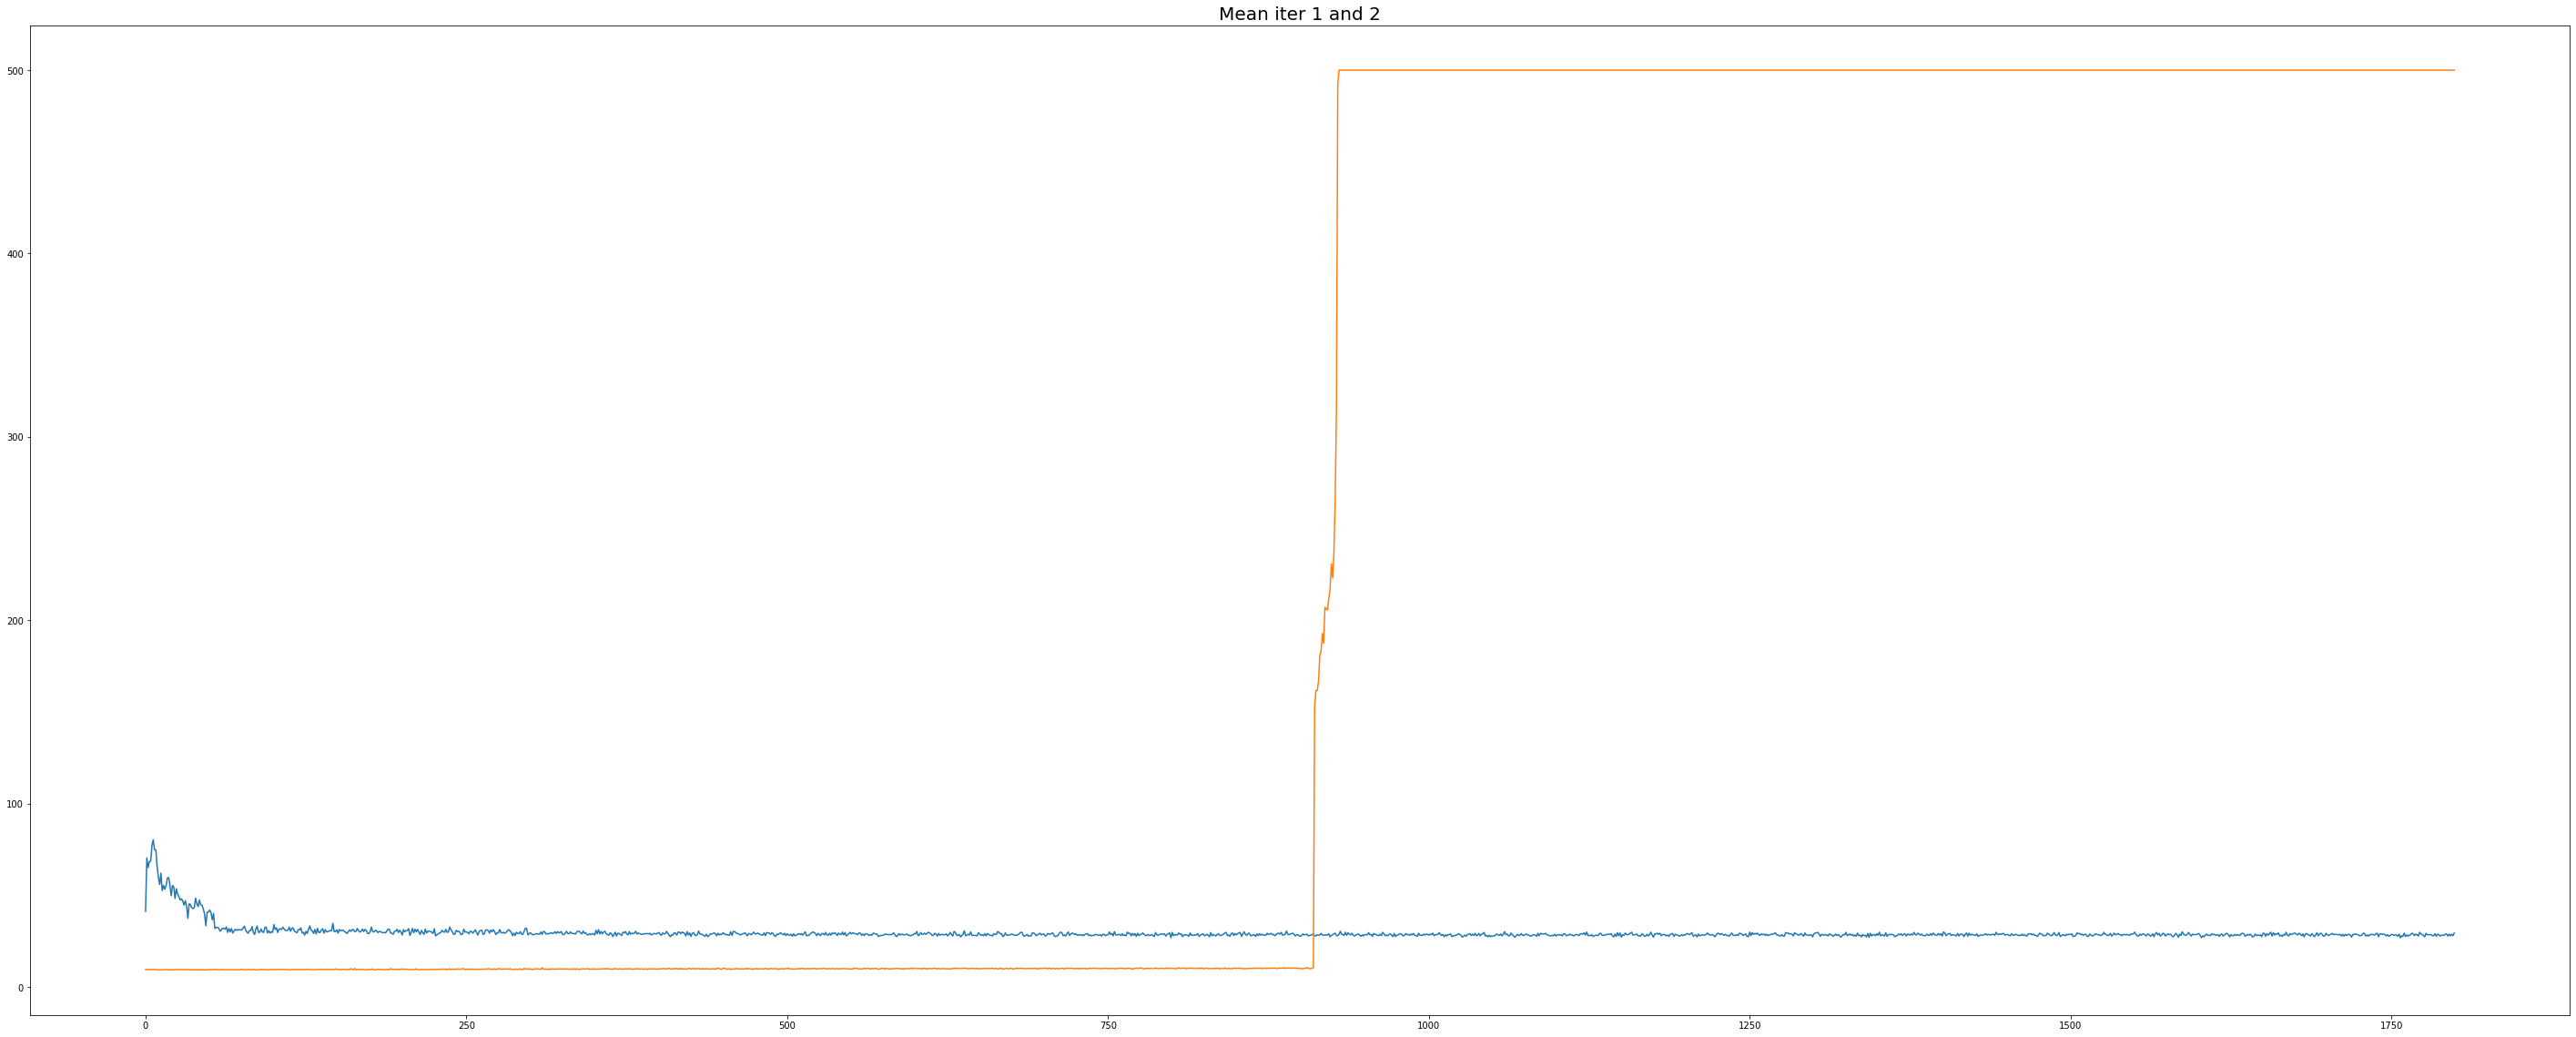

In [148]:
plot_mean(episodes_cp[0], np.array(rewards_cp[0]), np.array(rewards_cp[1]), "Mean iter 1 and 2")

# Lunar Lander:

In [80]:
env,nS,nA,phi,dname=prepLunarLander()
evals_ll = []
eposodes_ll = []
for i in range(2):
    print("running iteration: ",i)
    ret = sarsa(env,nS,nA,phi,episodes=100000,alpha=0.01,gamma=1)
    evals_ll.append(ret[0])
    eposodes_ll.append(ret[1])

LunarLander 12 4
running iteration:  0
running iteration:  1


In [102]:
evals_ll[0][-10:]

[53.07064711680933,
 56.11111676455354,
 46.554207234768874,
 52.63584819733049,
 52.97494385889184,
 53.12594904375454,
 48.74092213635586,
 52.84103710604564,
 49.629539633924395,
 50.99526556121535]

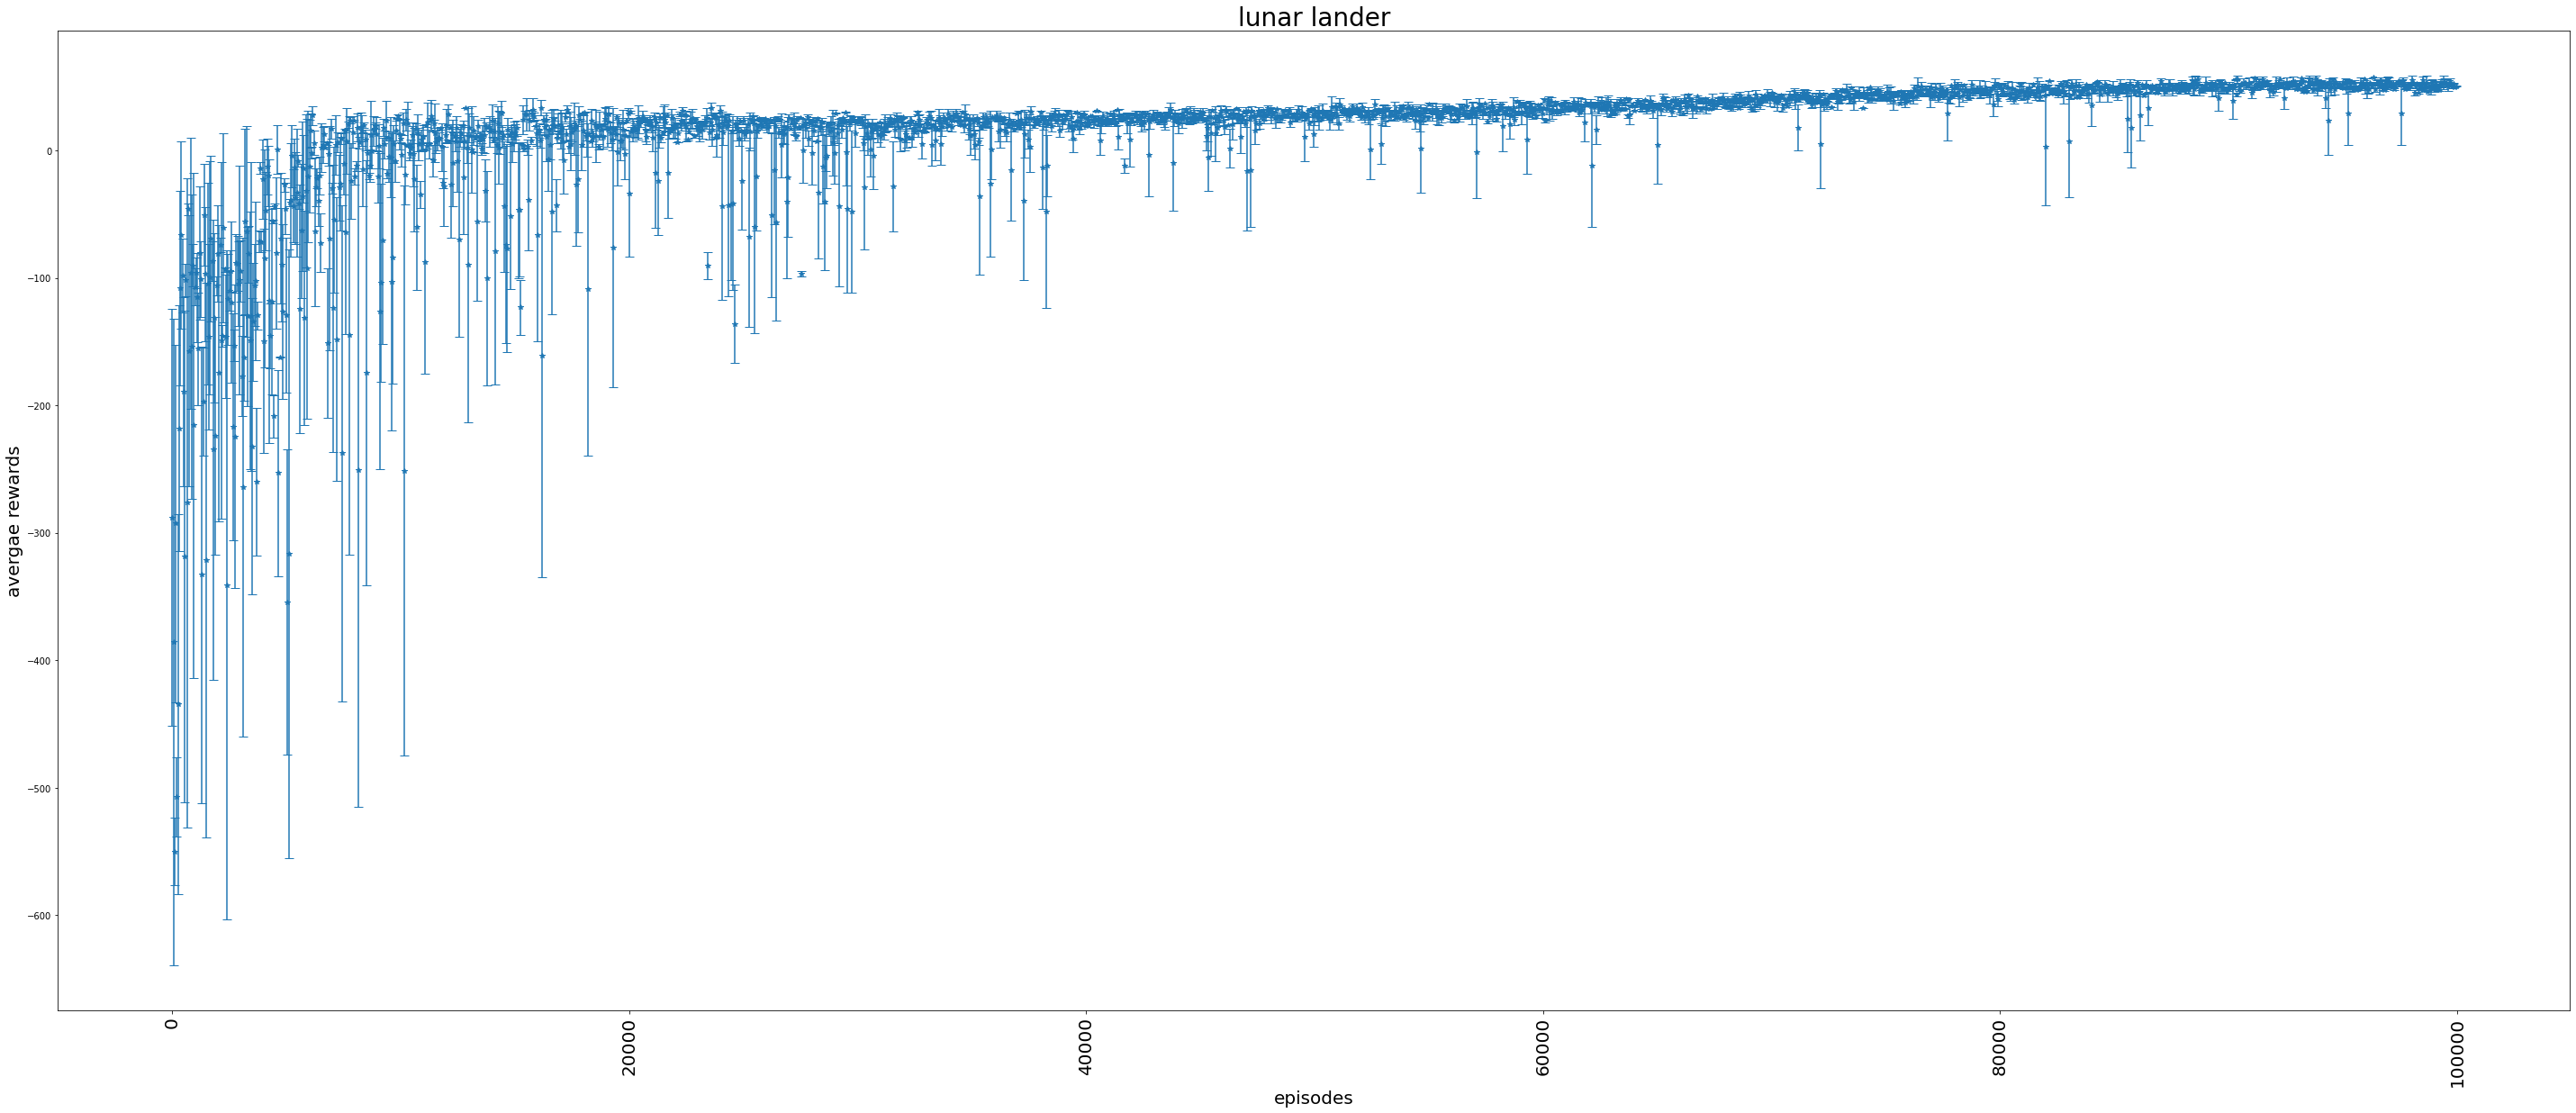

In [153]:
plot2(eposodes_ll[0], np.array(evals_ll[0]), np.array(evals_ll[1]), "lunar lander")

#  LL

## Implementation:
1. Run for 100000 episides.
2. Run for 2 iterations
3. Best results optained with decaying epsilon.

## Results:

1. The mean reward becomes positive in about 30000 episodes

2. Last 10 average rewards for one of the runs-[53.07064711680933, 56.11111676455354, 46.554207234768874, 52.63584819733049, 52.97494385889184, 53.12594904375454, 48.74092213635586, 52.84103710604564, 49.629539633924395, 50.99526556121535]

3. There are multiple optimas as clear from the above rewards

4. The standard deviation converges(tends to positive values) if we let the model run for huge number of episodes

5. The mean reward tends to +50 towards with 100000 episodes